In [46]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

OSError: ignored

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
from fastbook import *
from fastai.vision.all import *

In [49]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [50]:
# define the path of my dataset
path_int = Path('/content/drive/My Drive/Colab Notebooks'); path

Path('/content/drive/My Drive/Colab Notebooks/soccerBasketball')

cd /content/drive/My Drive/Colab Notebooks/soccerBasketball

In [51]:
path = path_int/'soccerBasketball'

In [52]:
# see what's inside that path i just defined
path.ls()

(#3) [Path('/content/drive/My Drive/Colab Notebooks/soccerBasketball/valid'),Path('/content/drive/My Drive/Colab Notebooks/soccerBasketball/models'),Path('/content/drive/My Drive/Colab Notebooks/soccerBasketball/train')]

In [53]:
# to take a look at what image names are in our dataset
(path/'train'/'basketball').ls()

(#69) [Path('/content/drive/My Drive/Colab Notebooks/soccerBasketball/train/basketball/nc0256abf502efa34.jpg'),Path('/content/drive/My Drive/Colab Notebooks/soccerBasketball/train/basketball/nc36a2e58f0fceb10.jpg'),Path('/content/drive/My Drive/Colab Notebooks/soccerBasketball/train/basketball/nb9b8519ad5735ee4.jpg'),Path('/content/drive/My Drive/Colab Notebooks/soccerBasketball/train/basketball/ncbdfc5549fd06095.jpg'),Path('/content/drive/My Drive/Colab Notebooks/soccerBasketball/train/basketball/na9061315dd0bb955.jpg'),Path('/content/drive/My Drive/Colab Notebooks/soccerBasketball/train/basketball/n2788147877e5ebb6.jpg'),Path('/content/drive/My Drive/Colab Notebooks/soccerBasketball/train/basketball/n000000524027.jpg'),Path('/content/drive/My Drive/Colab Notebooks/soccerBasketball/train/basketball/n00480993_32155.jpg'),Path('/content/drive/My Drive/Colab Notebooks/soccerBasketball/train/basketball/n863960ac3b291df2.jpg'),Path('/content/drive/My Drive/Colab Notebooks/soccerBasketball/

In [54]:
# now we creat a data block using DataBlock API
socBas = DataBlock(blocks = (ImageBlock, CategoryBlock), # we wanna have a tuple of image files and their target
                   get_items=get_image_files, # get a list of all the images recursively from all the folders within path
                   splitter=RandomSplitter(valid_pct=0.2, seed=42), # randomly spliting 20% of all dataset as validation and keep this the same using seed
                   get_y=parent_label, # a function to get label from parent folder of each image
                   item_tfms=Resize(600), # presize images to a large size
                   batch_tfms=aug_transforms(size=224, min_scale=0.9), # resize to 224 for training with minimum scale defined
                   )
# create dataloaders object
dls = socBas.dataloaders(path/'train')

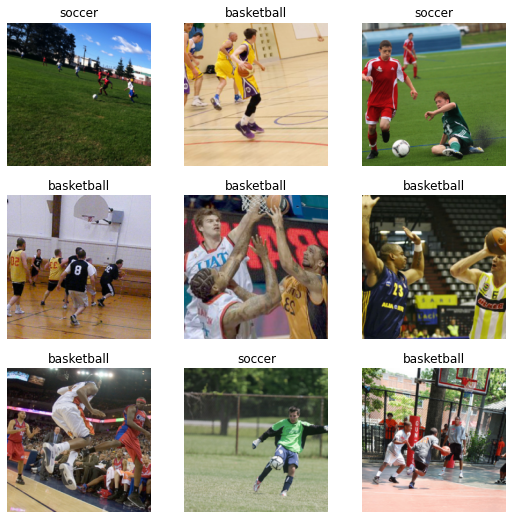

In [55]:
# show 9 sample images from our dataset as well as their labels
dls.show_batch(nrows=3, ncols=3)

In [56]:
# create a sample batch to see what's happening underline
socBas.summary(path/'train')

Setting-up type transforms pipelines
Found 167 items
2 datasets of sizes 134,33
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /content/drive/My Drive/Colab Notebooks/soccerBasketball/train/basketball/n2d08fd379017b6ca.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=285x429
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /content/drive/My Drive/Colab Notebooks/soccerBasketball/train/basketball/n2d08fd379017b6ca.jpg
    applying parent_label gives
      basketball
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(0)

Final sample: (PILImage mode=RGB size=285x429, TensorCategory(0))


Setting up after_item: Pipeline: Resize -- {'size': (600, 600), 'method': 'crop', 'pad_mode': 'reflection', 'resampl

In [57]:
# train the model
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.317879,1.619429,0.454545,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.760419,0.312260,0.181818,00:03
1,0.509461,0.067295,0.000000,00:03


In [58]:
# getting a batch of real data from our dataloaders
x, y = dls.one_batch()

In [59]:
# it is either 0 or 1 which shows we only have 2 categories
y

TensorCategory([1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1],
       device='cuda:0')

In [60]:
# shape is 64 which is equal to batch size
y.shape

torch.Size([64])

In [61]:
# show the probability of being in each of the 2 categories
preds, _ = learn.get_preds(dl=[(x,y)])
preds[0]

TensorImage([3.7434e-04, 9.9963e-01])

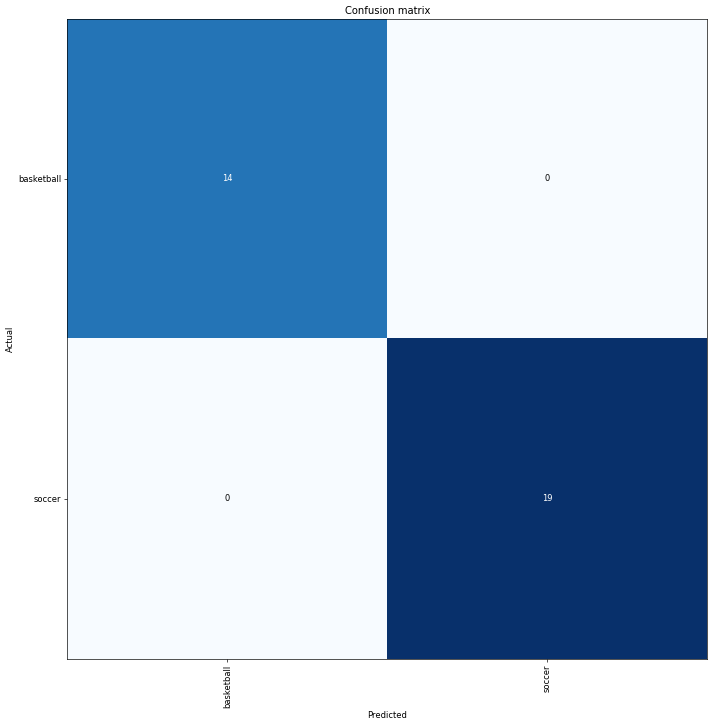

In [63]:
# plotting the confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [64]:
# show the 5 most incorrect predicted
interp.most_confused(min_val=5)

[]

In [65]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
# error is too high since we picked a high learning rate
# here we use transfer learning
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,0.728328,1.058479,0.030303,00:03


epoch,train_loss,valid_loss,error_rate,time
0,1.690830,34.488228,0.696970,00:03


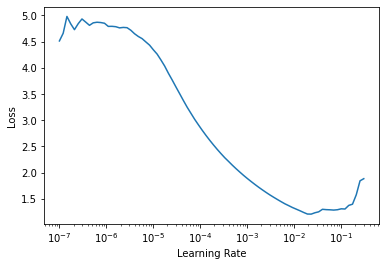

In [66]:
# plot loss vs learning rate to obtain the best learning rate
lr_min, lr_steep = learn.lr_find()

In [67]:
# we then print the minimum value of the plot
print(f"Minimum/10: {lr_min: .2e}, steepest point: {lr_steep: .2}")

Minimum/10:  2.29e-03, steepest point:  1.7e-05


In [73]:
learn.fine_tune(2, base_lr=3e-03)

epoch,train_loss,valid_loss,error_rate,time
0,0.180522,0.758704,0.090909,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.258662,0.455005,0.090909,00:03
1,0.137175,0.297623,0.090909,00:03


In [74]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
# here we don't want to use transfer learning
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.537357,1.259531,0.363636,00:03
1,0.928831,0.600979,0.212121,00:03
2,0.681006,0.243732,0.090909,00:03


SuggestedLRs(lr_min=1.3182566908653825e-05, lr_steep=6.309573450380412e-07)

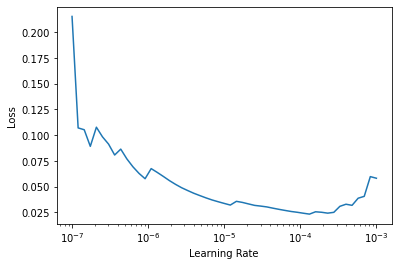

In [77]:
# unfreezing pretrained layers
learn.unfreeze()
learn.lr_find()

In [78]:
learn.fit_one_cycle(6, 1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.051719,1.314503,0.121212,00:03
1,0.066029,1.017759,0.121212,00:03
2,0.052773,0.717625,0.090909,00:03
3,0.038839,0.402625,0.090909,00:03
4,0.033985,0.253787,0.090909,00:03
5,0.029085,0.132176,0.090909,00:03


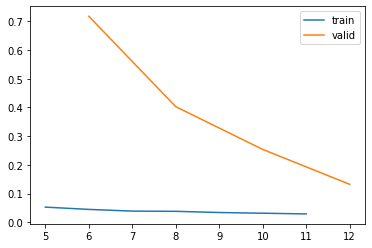

In [79]:
# graph of training and validation loss
learn.recorder.plot_loss()

In [82]:
# using deeper layer resnet50
from fastai.callback.fp16 import *
# converting to float16 for faster training
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
# here we don't want to use transfer learning
learn.fit_one_cycle(6, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,1.489648,1.247018,0.696970,00:03
1,1.429875,1.161661,0.757576,00:03
2,1.412682,1.071777,0.757576,00:03
3,1.410191,0.194513,0.030303,00:03
4,1.155420,0.083535,0.060606,00:03
5,0.956293,0.085373,0.030303,00:03


In [83]:
# using deeper layer resnet50 and using fine tune instead
from fastai.callback.fp16 import *
# converting to float16 for faster training
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
# here we don't want to use transfer learning
learn.fine_tune(6, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,1.378855,0.780452,0.363636,00:03
1,1.411679,0.759677,0.393939,00:03
2,1.372118,0.743138,0.393939,00:03


epoch,train_loss,valid_loss,error_rate,time
0,1.218286,0.725660,0.333333,00:03
1,1.032143,0.037274,0.000000,00:03
2,0.714994,0.008957,0.000000,00:03
3,0.541449,0.035545,0.030303,00:03
4,0.444625,0.051956,0.030303,00:03
5,0.373891,0.055601,0.030303,00:03


In [84]:
# save our trained model
learn.save('new_model')

Path('models/new_model.pth')

In [101]:
from fastai.vision import *

In [112]:
# testing our model
path111 = Path('/content/drive/My Drive/Colab Notebooks/')
imggg = PILImage.create(path111/'073d9ef15524655ece0056183736ce49.jpg')
learn.predict(imggg)

('soccer', TensorImage(1), TensorImage([1.8266e-07, 1.0000e+00]))

In [113]:
img3 = PILImage.create(path111/'1000x-1.jpg')
learn.predict(img3)

('soccer', TensorImage(1), TensorImage([4.8024e-08, 1.0000e+00]))

In [117]:
img2 = PILImage.create(path111/'usa_today_13746018.0.webp')
learn.predict(img2)

('basketball', TensorImage(0), TensorImage([1.0000e+00, 1.2626e-08]))